# Import modules

We probably need all the same stuff used in the simulation, plus matplotlib. I don't know this for sure, but I think it is true because I was lazy and used pickle instead of coming up with a data structure.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import itertools
from copy import deepcopy,copy
import numpy as np
import multiprocessing as mp
import pickle
import glob
import pandas as pd

##Fwdpy and libsequence
import fwdpy11 as fp11 #fwdpy11 
from fwdpy11.model_params import SlocusParams
import fwdpy11.wright_fisher as wf
import fwdpy11.sampling as fps
import libsequence.polytable as polyt
from libsequence.summstats import PolySIM

#My stuff
import clonal  #This is my fwdpy11 extension module for clonal evolution
import RecordStats # My recorder class



# Read in pickled data


In [2]:
rec_files=glob.glob('data/revisions/recessive/recessive_grape*.pkl')
add_files=glob.glob('data/revisions/additive/additive_grape*.pkl')

rec_files[0]
add_files[0]

'data/revisions/additive/additive_grape.123.pkl'

In [3]:
rec_pkl_data = [pickle.load(open(i,'rb')) for i in rec_files]
add_pkl_data = [pickle.load(open(i,'rb')) for i in add_files]

# Population size history

In [4]:
generations = rec_pkl_data[0]['ancestral'].generation + rec_pkl_data[0]['const_decl'].generation + rec_pkl_data[0]['const_domest_out'].generation
ancestral_N = rec_pkl_data[0]['ancestral'].N
const_N = ancestral_N + rec_pkl_data[0]['const_decl'].N + rec_pkl_data[0]['const_domest_out'].N
lin_N = ancestral_N + rec_pkl_data[0]['lin_decl'].N + rec_pkl_data[0]['lin_domest_out'].N
disc_N = ancestral_N + [ancestral_N[0]] + rec_pkl_data[0]['disc_decl'].N[1:] + rec_pkl_data[0]['disc_domest_out'].N
exp_N = ancestral_N + rec_pkl_data[0]['exp_decl'].N + rec_pkl_data[0]['exp_domest_out'].N


In [5]:
def scale_time(gen,maxgen,N):
    st = [(i - maxgen)/(2.0*N) for i in gen]
    return(st)


In [6]:
scaled_time = scale_time(generations,
                               np.max(generations),
                               np.max(const_N))

deltaN = len(const_N) - len(ancestral_N)


In [7]:
scaled_time[392]

-0.003375

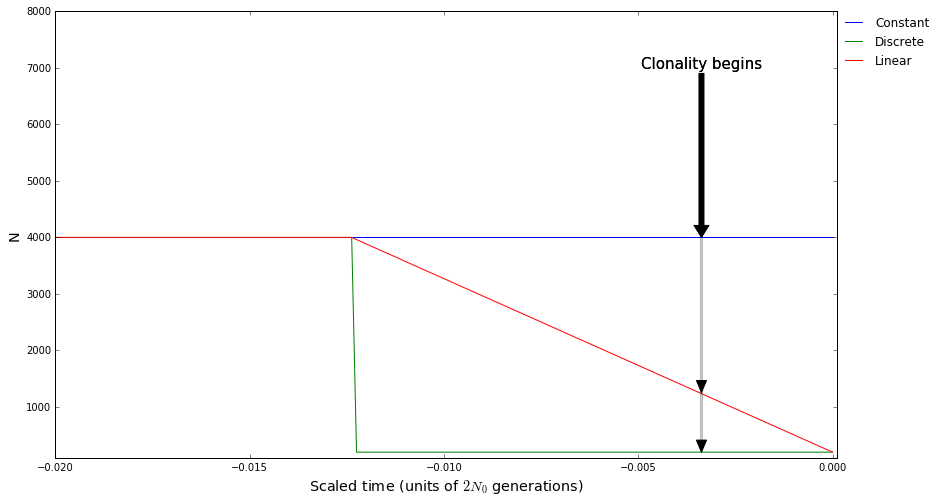

In [9]:
fig=plt.figure(figsize=(14,8))
line1, = plt.plot(scaled_time,const_N,label='Constant')
line2, = plt.plot(scaled_time,disc_N,label='Discrete')
line3, = plt.plot(scaled_time,lin_N,label='Linear')
#line4, = plt.plot(scaled_time,exp_N,label='Exponential')
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size='x-large')
plt.ylabel("N",size='x-large')
plt.xlim(-0.02,0.0001)
plt.ylim(np.min(disc_N)/2,np.max(const_N)*2)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)

plt.annotate('Clonality begins', xy=(scaled_time[392], 200), xytext=(scaled_time[392], 7000),
            arrowprops=dict(facecolor='black',alpha=0.2, shrink=0,width=2,headwidth=10),size=15, horizontalalignment='center'
            )
plt.annotate('', xy=(scaled_time[392], 200), xytext=(scaled_time[392], 201),
            arrowprops=dict(facecolor='black',alpha=1, shrink=0,width=2,headwidth=10),size=15, horizontalalignment='center'
            )
plt.annotate('', xy=(scaled_time[392], 1255), xytext=(scaled_time[392], 1256),
            arrowprops=dict(facecolor='black', alpha=1,shrink=0.05,width=2,headwidth=10),size=15, horizontalalignment='center'
            )
plt.annotate('Clonality begins', xy=(scaled_time[392], 4000), xytext=(scaled_time[392], 7000),
            arrowprops=dict(facecolor='black', shrink=0,width=5,headwidth=15),size=15, horizontalalignment='center'
            )
fig.savefig('plots/demogs.pdf',bbox_inches='tight')
plt.show()



# Classes for tajima's D and total deleterious mutations

In [11]:
class TajD:
    def __init__(self):
        self.ancestral_tajd = []
        self.const_outcross_tajd = []
        self.lin_outcross_tajd = []
        self.disc_outcross_tajd = []
        self.exp_outcross_tajd = []
        self.const_clonal_tajd = []
        self.lin_clonal_tajd = []
        self.disc_clonal_tajd = []
        self.exp_clonal_tajd = []
    def __call__(self,pkl_data):
        self.ancestral_tajd = pd.DataFrame([i['ancestral'].neutral_tajd for i in pkl_data])
        
        ###Outcrossing
        self.const_outcross_tajd = pd.concat([self.ancestral_tajd,
        pd.DataFrame([i['const_decl'].neutral_tajd for 
                  i in pkl_data]),
        pd.DataFrame([i['const_domest_out'].neutral_tajd for 
                  i in pkl_data])],axis=1)
        
        self.lin_outcross_tajd = pd.concat([self.ancestral_tajd,
        pd.DataFrame([i['lin_decl'].neutral_tajd for 
                  i in pkl_data]),
        pd.DataFrame([i['lin_domest_out'].neutral_tajd for 
                  i in pkl_data])],axis=1)
        
        self.exp_outcross_tajd = pd.concat([self.ancestral_tajd,
        pd.DataFrame([i['exp_decl'].neutral_tajd for 
                  i in pkl_data]),
        pd.DataFrame([i['exp_domest_out'].neutral_tajd for 
                  i in pkl_data])],axis=1)
        
        self.disc_outcross_tajd = pd.concat([self.ancestral_tajd,
        pd.DataFrame([i['disc_decl'].neutral_tajd for 
                  i in pkl_data]),
        pd.DataFrame([i['disc_domest_out'].neutral_tajd for 
                  i in pkl_data])],axis=1)
        
        ###Clonal
        self.const_clonal_tajd = pd.concat([self.ancestral_tajd,
        pd.DataFrame([i['const_decl'].neutral_tajd for 
                  i in pkl_data]),
        pd.DataFrame([i['const_domest_clonal'].neutral_tajd for 
                  i in pkl_data])],axis=1)
        
        self.lin_clonal_tajd = pd.concat([self.ancestral_tajd,
        pd.DataFrame([i['lin_decl'].neutral_tajd for 
                  i in pkl_data]),
        pd.DataFrame([i['lin_domest_clonal'].neutral_tajd for 
                  i in pkl_data])],axis=1)
        
        self.exp_clonal_tajd = pd.concat([self.ancestral_tajd,
        pd.DataFrame([i['exp_decl'].neutral_tajd for 
                  i in pkl_data]),
        pd.DataFrame([i['exp_domest_clonal'].neutral_tajd for 
                  i in pkl_data])],axis=1)
        
        self.disc_clonal_tajd = pd.concat([self.ancestral_tajd,
        pd.DataFrame([i['disc_decl'].neutral_tajd for 
                  i in pkl_data]),
        pd.DataFrame([i['disc_domest_clonal'].neutral_tajd for 
                  i in pkl_data])],axis=1)

In [12]:
add_tajd = TajD()
add_tajd(add_pkl_data)

In [13]:
add_tajd.lin_outcross_tajd.shape

(500, 420)

In [14]:
def total_muts(recorder):
    total_muts = [i + 2*j for i,j in 
                     zip(recorder.mean_deleterious_per_diploid,
                    recorder.fixed_deleterious)]
    return(total_muts)


class delMut:
    def __init__(self):
        self.ancestral_delmut = []
        self.const_outcross_delmut = []
        self.lin_outcross_delmut = []
        self.disc_outcross_delmut = []
        self.exp_outcross_delmut = []
        self.const_clonal_delmut = []
        self.lin_clonal_delmut = []
        self.disc_clonal_delmut = []
        self.exp_clonal_delmut = []
    def __call__(self,pkl_data):
        self.ancestral_delmut = pd.DataFrame([total_muts(i['ancestral']) for i in pkl_data])
        
        ###Outcrossing
        self.const_outcross_delmut = pd.concat([self.ancestral_delmut,
        pd.DataFrame([total_muts(i['const_decl']) for 
                  i in pkl_data]),
        pd.DataFrame([total_muts(i['const_domest_out']) for 
                  i in pkl_data])],axis=1)
        
        self.lin_outcross_delmut = pd.concat([self.ancestral_delmut,
        pd.DataFrame([total_muts(i['lin_decl']) for 
                  i in pkl_data]),
        pd.DataFrame([total_muts(i['lin_domest_out']) for 
                  i in pkl_data])],axis=1)
        
        self.exp_outcross_delmut = pd.concat([self.ancestral_delmut,
        pd.DataFrame([total_muts(i['exp_decl']) for 
                  i in pkl_data]),
        pd.DataFrame([total_muts(i['exp_domest_out']) for 
                  i in pkl_data])],axis=1)
        
        self.disc_outcross_delmut = pd.concat([self.ancestral_delmut,
        pd.DataFrame([total_muts(i['disc_decl']) for 
                  i in pkl_data]),
        pd.DataFrame([total_muts(i['disc_domest_out']) for 
                  i in pkl_data])],axis=1)
        
        ###Clonal
        self.const_clonal_delmut = pd.concat([self.ancestral_delmut,
        pd.DataFrame([total_muts(i['const_decl']) for 
                  i in pkl_data]),
        pd.DataFrame([total_muts(i['const_domest_clonal']) for 
                  i in pkl_data])],axis=1)
        
        self.lin_clonal_delmut = pd.concat([self.ancestral_delmut,
        pd.DataFrame([total_muts(i['lin_decl']) for 
                  i in pkl_data]),
        pd.DataFrame([total_muts(i['lin_domest_clonal']) for 
                  i in pkl_data])],axis=1)
        
        self.exp_clonal_delmut = pd.concat([self.ancestral_delmut,
        pd.DataFrame([total_muts(i['exp_decl']) for 
                  i in pkl_data]),
        pd.DataFrame([total_muts(i['exp_domest_clonal']) for 
                  i in pkl_data])],axis=1)
        
        self.disc_clonal_delmut = pd.concat([self.ancestral_delmut,
        pd.DataFrame([total_muts(i['disc_decl']) for 
                  i in pkl_data]),
        pd.DataFrame([total_muts(i['disc_domest_clonal']) for 
                  i in pkl_data])],axis=1)
        
        


In [15]:
class totLoad:
    def __init__(self):
        self.ancestral_load = []
        self.const_outcross_load = []
        self.lin_outcross_load = []
        self.disc_outcross_load = []
        self.exp_outcross_load = []
        self.const_clonal_load = []
        self.lin_clonal_load = []
        self.disc_clonal_load = []
        self.exp_clonal_load = []
    def __call__(self,pkl_data):
        self.ancestral_load = pd.DataFrame([i['ancestral'].total_load for i in pkl_data])
        
        ###Outcrossing
        self.const_outcross_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['const_decl'].total_load for 
                  i in pkl_data]),
        pd.DataFrame([i['const_domest_out'].total_load for 
                  i in pkl_data])],axis=1)
        
        self.lin_outcross_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['lin_decl'].total_load for 
                  i in pkl_data]),
        pd.DataFrame([i['lin_domest_out'].total_load for 
                  i in pkl_data])],axis=1)
        
        self.exp_outcross_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['exp_decl'].total_load for 
                  i in pkl_data]),
        pd.DataFrame([i['exp_domest_out'].total_load for 
                  i in pkl_data])],axis=1)
        
        self.disc_outcross_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['disc_decl'].total_load for 
                  i in pkl_data]),
        pd.DataFrame([i['disc_domest_out'].total_load for 
                  i in pkl_data])],axis=1)
        
        ###Clonal
        self.const_clonal_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['const_decl'].total_load for 
                  i in pkl_data]),
        pd.DataFrame([i['const_domest_clonal'].total_load for 
                  i in pkl_data])],axis=1)
        
        self.lin_clonal_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['lin_decl'].total_load for 
                  i in pkl_data]),
        pd.DataFrame([i['lin_domest_clonal'].total_load for 
                  i in pkl_data])],axis=1)
        
        self.exp_clonal_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['exp_decl'].total_load for 
                  i in pkl_data]),
        pd.DataFrame([i['exp_domest_clonal'].total_load for 
                  i in pkl_data])],axis=1)
        
        self.disc_clonal_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['disc_decl'].total_load for 
                  i in pkl_data]),
        pd.DataFrame([i['disc_domest_clonal'].total_load for 
                  i in pkl_data])],axis=1)

In [16]:
class fixedLoad:
    def __init__(self):
        self.ancestral_load = []
        self.const_outcross_load = []
        self.lin_outcross_load = []
        self.disc_outcross_load = []
        self.exp_outcross_load = []
        self.const_clonal_load = []
        self.lin_clonal_load = []
        self.disc_clonal_load = []
        self.exp_clonal_load = []
    def __call__(self,pkl_data):
        self.ancestral_load = pd.DataFrame([i['ancestral'].fixed_load for i in pkl_data])
        
        ###Outcrossing
        self.const_outcross_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['const_decl'].fixed_load for 
                  i in pkl_data]),
        pd.DataFrame([i['const_domest_out'].fixed_load for 
                  i in pkl_data])],axis=1)
        
        self.lin_outcross_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['lin_decl'].fixed_load for 
                  i in pkl_data]),
        pd.DataFrame([i['lin_domest_out'].fixed_load for 
                  i in pkl_data])],axis=1)
        
        self.exp_outcross_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['exp_decl'].fixed_load for 
                  i in pkl_data]),
        pd.DataFrame([i['exp_domest_out'].fixed_load for 
                  i in pkl_data])],axis=1)
        
        self.disc_outcross_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['disc_decl'].fixed_load for 
                  i in pkl_data]),
        pd.DataFrame([i['disc_domest_out'].fixed_load for 
                  i in pkl_data])],axis=1)
        
        ###Clonal
        self.const_clonal_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['const_decl'].fixed_load for 
                  i in pkl_data]),
        pd.DataFrame([i['const_domest_clonal'].fixed_load for 
                  i in pkl_data])],axis=1)
        
        self.lin_clonal_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['lin_decl'].fixed_load for 
                  i in pkl_data]),
        pd.DataFrame([i['lin_domest_clonal'].fixed_load for 
                  i in pkl_data])],axis=1)
        
        self.exp_clonal_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['exp_decl'].fixed_load for 
                  i in pkl_data]),
        pd.DataFrame([i['exp_domest_clonal'].fixed_load for 
                  i in pkl_data])],axis=1)
        
        self.disc_clonal_load = pd.concat([self.ancestral_load,
        pd.DataFrame([i['disc_decl'].fixed_load for 
                  i in pkl_data]),
        pd.DataFrame([i['disc_domest_clonal'].fixed_load for 
                  i in pkl_data])],axis=1)

# Extract summary statistics

In [17]:
add_delmut = delMut()
rec_delmut = delMut()
add_delmut(add_pkl_data)
rec_delmut(rec_pkl_data)

#disc_add_delmut = delMut()
#disc_rec_delmut = delMut()
#disc_add_delmut(disc_add_pkl_data)
#disc_rec_delmut(disc_rec_pkl_data)

add_tajd = TajD()
rec_tajd = TajD()
add_tajd(add_pkl_data)
rec_tajd(rec_pkl_data)

##disc_add_tajd = TajD()
##disc_rec_tajd = TajD()
#disc_add_tajd(disc_add_pkl_data)
#disc_rec_tajd(disc_rec_pkl_data)

add_load = totLoad()
rec_load = totLoad()
add_load(add_pkl_data)
rec_load(rec_pkl_data)

add_fixed_load = fixedLoad()
rec_fixed_load = fixedLoad()
add_fixed_load (add_pkl_data)
rec_fixed_load (rec_pkl_data)

# Linear decline plots

# Tajima's D


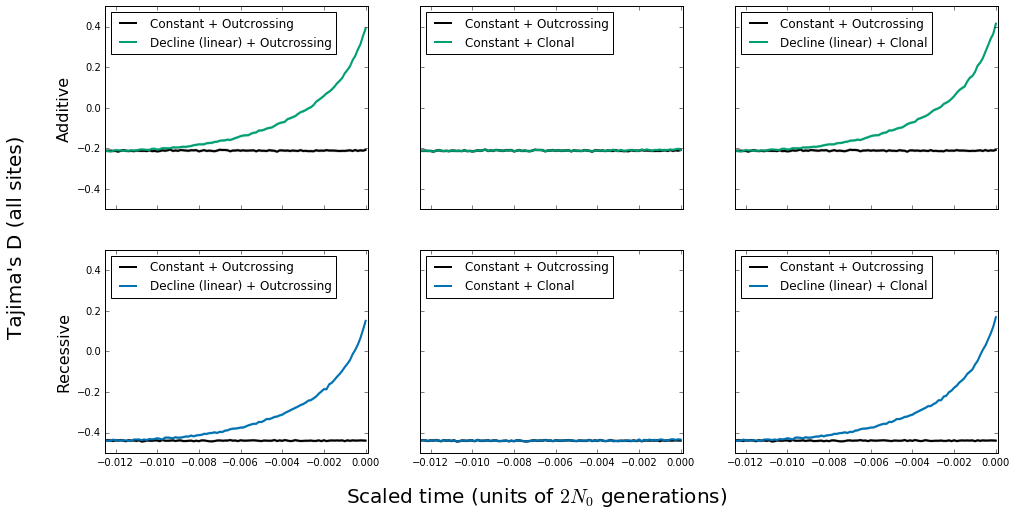

In [118]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=True,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_tajd.lin_outcross_tajd.mean(),
                 label='Decline (linear) + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_tajd.lin_outcross_tajd.mean() - np.sqrt(add_tajd.lin_outcross_tajd.var()/500),
add_tajd.lin_outcross_tajd.mean() + np.sqrt(add_tajd.lin_outcross_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')

#const out vs const clonal
axarr[0,1].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_tajd.const_clonal_tajd.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_tajd.const_clonal_tajd.mean() - np.sqrt(add_tajd.const_clonal_tajd.var()/500),
add_tajd.const_clonal_tajd.mean() + np.sqrt(add_tajd.const_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_tajd.lin_clonal_tajd.mean(),
                 label='Decline (linear) + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_tajd.lin_clonal_tajd.mean() - np.sqrt(add_tajd.lin_clonal_tajd.var()/500),
add_tajd.lin_clonal_tajd.mean() + np.sqrt(add_tajd.lin_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')

#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_tajd.lin_outcross_tajd.mean(),
                 label='Decline (linear) + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_tajd.lin_outcross_tajd.mean() - np.sqrt(rec_tajd.lin_outcross_tajd.var()/500),
rec_tajd.lin_outcross_tajd.mean() + np.sqrt(rec_tajd.lin_outcross_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_tajd.const_clonal_tajd.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_tajd.const_clonal_tajd.mean() - np.sqrt(rec_tajd.const_clonal_tajd.var()/500),
rec_tajd.const_clonal_tajd.mean() + np.sqrt(rec_tajd.const_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')
#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_tajd.lin_clonal_tajd.mean(),
                 label='Decline (linear) + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_tajd.lin_clonal_tajd.mean() - np.sqrt(rec_tajd.lin_clonal_tajd.var()/500),
rec_tajd.lin_clonal_tajd.mean() + np.sqrt(rec_tajd.lin_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')

#Global
plt.xlim(-0.0125,0.0001)
#plt.xlim(-5,0.0001)

plt.ylim(-.5,0.5)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Tajima's D (all sites)",size=20, va='center', rotation='vertical')
#f.savefig('plots/lin_tajd_time_combined.pdf')
plt.show()

# Deleterious Mutations

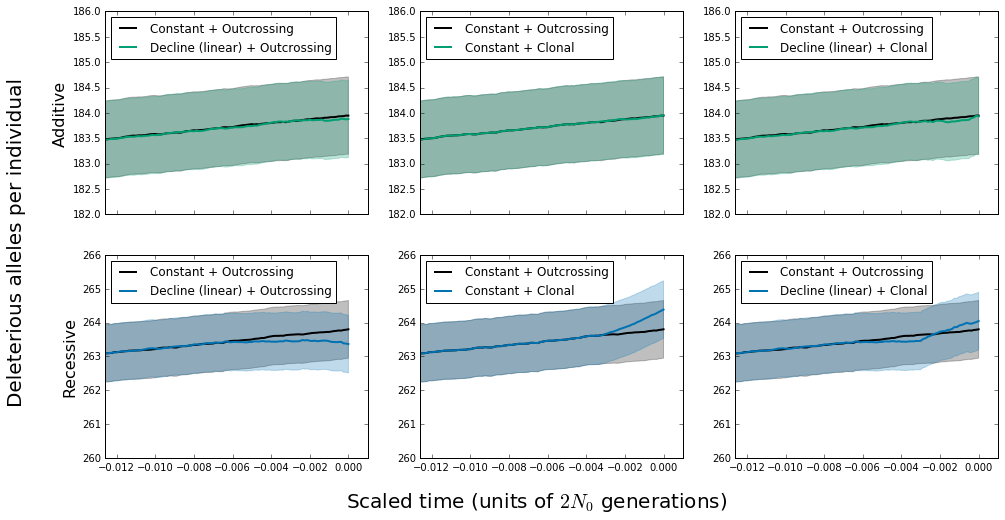

In [93]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=False,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_delmut.lin_outcross_delmut.mean(),
                 label='Decline (linear) + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_delmut.lin_outcross_delmut.mean() - np.sqrt(add_delmut.lin_outcross_delmut.var()/500),
add_delmut.lin_outcross_delmut.mean() + np.sqrt(add_delmut.lin_outcross_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')

#const out vs const clonal
axarr[0,1].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_delmut.const_clonal_delmut.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_delmut.const_clonal_delmut.mean() - np.sqrt(add_delmut.const_clonal_delmut.var()/500),
add_delmut.const_clonal_delmut.mean() + np.sqrt(add_delmut.const_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_delmut.lin_clonal_delmut.mean(),
                 label='Decline (linear) + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_delmut.lin_clonal_delmut.mean() - np.sqrt(add_delmut.lin_clonal_delmut.var()/500),
add_delmut.lin_clonal_delmut.mean() + np.sqrt(add_delmut.lin_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')

#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_delmut.lin_outcross_delmut.mean(),
                 label='Decline (linear) + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_delmut.lin_outcross_delmut.mean() - np.sqrt(rec_delmut.lin_outcross_delmut.var()/500),
rec_delmut.lin_outcross_delmut.mean() + np.sqrt(rec_delmut.lin_outcross_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_delmut.const_clonal_delmut.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_delmut.const_clonal_delmut.mean() - np.sqrt(rec_delmut.const_clonal_delmut.var()/500),
rec_delmut.const_clonal_delmut.mean() + np.sqrt(rec_delmut.const_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_delmut.lin_clonal_delmut.mean(),
                 label='Decline (linear) + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_delmut.lin_clonal_delmut.mean() - np.sqrt(rec_delmut.lin_clonal_delmut.var()/500),
rec_delmut.lin_clonal_delmut.mean() + np.sqrt(rec_delmut.lin_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')

axarr[0,0].set_ylim(182,186)
axarr[0,1].set_ylim(182,186)
axarr[0,2].set_ylim(182,186)
axarr[1,0].set_ylim(260,266)
axarr[1,1].set_ylim(260,266)
axarr[1,2].set_ylim(260,266)


#Global
plt.xlim(-0.0126,0.001)
#plt.ylim(0,270)

f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Deleterious alleles per individual",size=20, va='center', rotation='vertical')
#f.savefig('plots/lin_delmut_time_combined.pdf')
plt.show()

# Deleterious mutation burden ratio

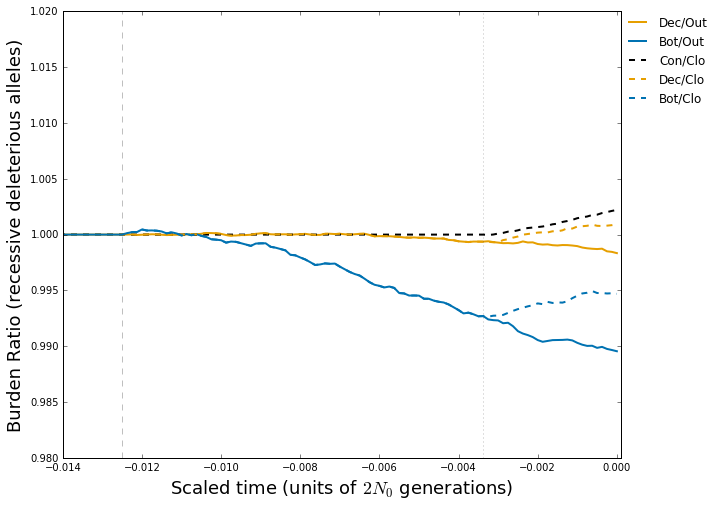

In [36]:
fig = plt.figure(figsize=(10,8))

#######Recessive
#const out vs bottle out

f1, = plt.plot(scaled_time,rec_delmut.lin_outcross_delmut.mean()/rec_delmut.const_outcross_delmut.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')
f2, = plt.plot(scaled_time,rec_delmut.disc_outcross_delmut.mean()/rec_delmut.const_outcross_delmut.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

f3, = plt.plot(scaled_time,rec_delmut.const_clonal_delmut.mean()/rec_delmut.const_outcross_delmut.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

f4, = plt.plot(scaled_time,rec_delmut.lin_clonal_delmut.mean()/rec_delmut.const_outcross_delmut.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')
f5, = plt.plot(scaled_time,rec_delmut.disc_clonal_delmut.mean()/rec_delmut.const_outcross_delmut.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')


#plt.axhline(y=1,color="black",linestyle='dotted')
plt.axvline(x=-0.0125,color="black",linestyle='dashed',alpha=0.25)
plt.axvline(x=-0.003375,color="black",linestyle='dotted',alpha=0.25)

plt.ylabel("Burden Ratio (recessive deleterious alleles)",size=18)
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size=18)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
plt.ylim(0.98,1.02)


#plt.annotate('Clonality begins', xy=(scaled_time[392], 1), xytext=(scaled_time[392], 1.01),
#            arrowprops=dict(facecolor='black', shrink=.01,width=1,headwidth=5),size=15, horizontalalignment='center'
#            )
#plt.annotate('Population size change', xy=(scaled_time[319], 1), xytext=(scaled_time[319], 1.01),
#            arrowprops=dict(facecolor='black', shrink=.01,width=1,headwidth=5),size=15, horizontalalignment='center'
#            )

#Global
plt.xlim(-0.014,0.0001)
fig.savefig('plots/rec_delmut_burdenratio_time_combined.pdf',bbox_inches='tight')
plt.show()

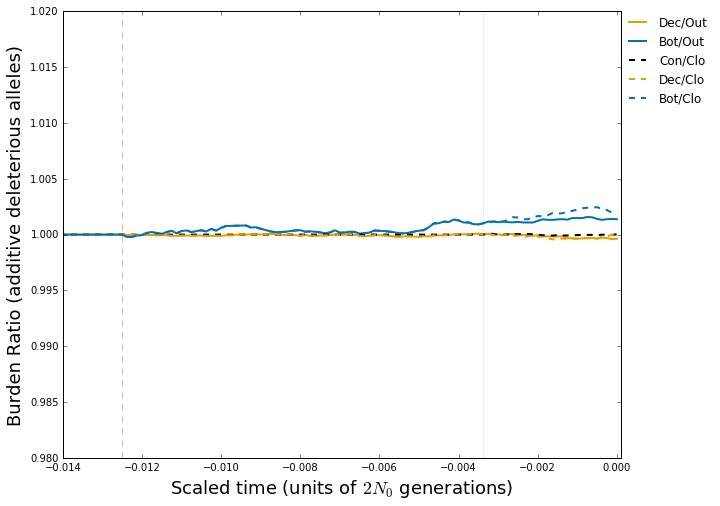

In [34]:
fig = plt.figure(figsize=(10,8))

#######Additive
#const out vs bottle out

f1, = plt.plot(scaled_time,add_delmut.lin_outcross_delmut.mean()/add_delmut.const_outcross_delmut.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')
f2, = plt.plot(scaled_time,add_delmut.disc_outcross_delmut.mean()/add_delmut.const_outcross_delmut.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

f3, = plt.plot(scaled_time,add_delmut.const_clonal_delmut.mean()/add_delmut.const_outcross_delmut.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

f4, = plt.plot(scaled_time,add_delmut.lin_clonal_delmut.mean()/add_delmut.const_outcross_delmut.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')
f5, = plt.plot(scaled_time,add_delmut.disc_clonal_delmut.mean()/add_delmut.const_outcross_delmut.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')


#plt.axhline(y=1,color="black",linestyle='dotted')
plt.axvline(x=-0.0125,color="black",linestyle='dashed',alpha=0.25)
plt.axvline(x=-0.003375,color="black",linestyle='dotted',alpha=0.25)

plt.ylabel("Burden Ratio (additive deleterious alleles)",size=18)
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size=18)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
plt.ylim(0.98,1.02)


#plt.annotate('Clonality begins', xy=(scaled_time[392], 1), xytext=(scaled_time[392], 1.01),
#            arrowprops=dict(facecolor='black', shrink=.01,width=1,headwidth=5),size=15, horizontalalignment='center'
#            )
#plt.annotate('Population size change', xy=(scaled_time[319], 1), xytext=(scaled_time[319], 1.01),
#            arrowprops=dict(facecolor='black', shrink=.01,width=1,headwidth=5),size=15, horizontalalignment='center'
#            )

#Global
plt.xlim(-0.014,0.0001)
fig.savefig('plots/add_delmut_burdenratio_time_combined.pdf',bbox_inches='tight')
plt.show()

# Load

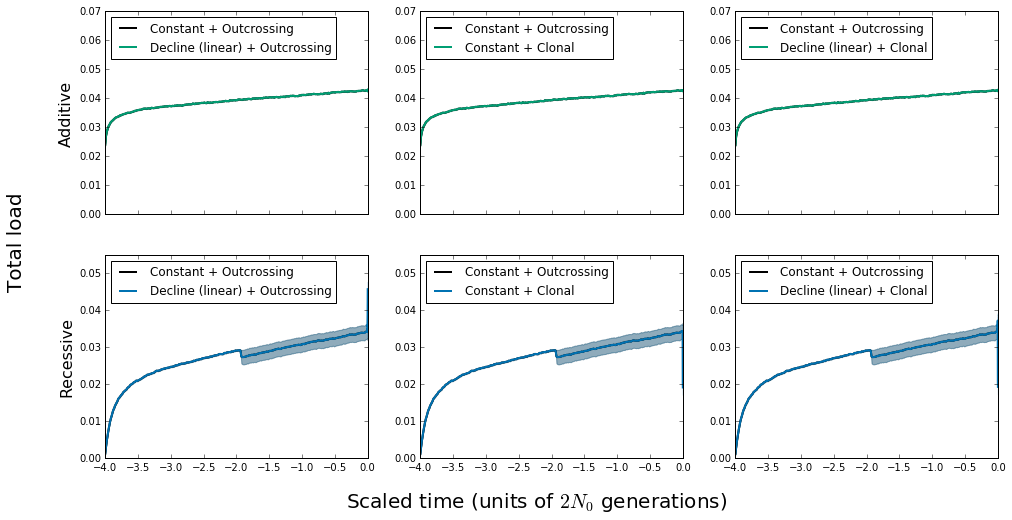

In [122]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=False,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_load.const_outcross_load.mean() - np.sqrt(add_load.const_outcross_load.var()/500),
add_load.const_outcross_load.mean() + np.sqrt(add_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_load.lin_outcross_load.mean(),
                 label='Decline (linear) + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_load.lin_outcross_load.mean() - np.sqrt(add_load.lin_outcross_load.var()/500),
add_load.lin_outcross_load.mean() + np.sqrt(add_load.lin_outcross_load.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')

#const out vs const clonal
axarr[0,1].plot(scaled_time,add_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_load.const_outcross_load.mean() - np.sqrt(add_load.const_outcross_load.var()/500),
add_load.const_outcross_load.mean() + np.sqrt(add_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_load.const_clonal_load.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_load.const_clonal_load.mean() - np.sqrt(add_load.const_clonal_load.var()/500),
add_load.const_clonal_load.mean() + np.sqrt(add_load.const_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_load.const_outcross_load.mean() - np.sqrt(add_load.const_outcross_load.var()/500),
add_load.const_outcross_load.mean() + np.sqrt(add_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_load.lin_clonal_load.mean(),
                 label='Decline (linear) + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_load.lin_clonal_load.mean() - np.sqrt(add_load.lin_clonal_load.var()/500),
add_load.lin_clonal_load.mean() + np.sqrt(add_load.lin_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')

#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_load.const_outcross_load.mean() - np.sqrt(rec_load.const_outcross_load.var()/500),
rec_load.const_outcross_load.mean() + np.sqrt(rec_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_load.lin_outcross_load.mean(),
                 label='Decline (linear) + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_load.lin_outcross_load.mean() - np.sqrt(rec_load.lin_outcross_load.var()/500),
rec_load.lin_outcross_load.mean() + np.sqrt(rec_load.lin_outcross_load.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_load.const_outcross_load.mean() - np.sqrt(rec_load.const_outcross_load.var()/500),
rec_load.const_outcross_load.mean() + np.sqrt(rec_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_load.const_clonal_load.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_load.const_clonal_load.mean() - np.sqrt(rec_load.const_clonal_load.var()/500),
rec_load.const_clonal_load.mean() + np.sqrt(rec_load.const_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')
#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_load.const_outcross_load.mean() - np.sqrt(rec_load.const_outcross_load.var()/500),
rec_load.const_outcross_load.mean() + np.sqrt(rec_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_load.lin_clonal_load.mean(),
                 label='Decline (linear) + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_load.lin_clonal_load.mean() - np.sqrt(rec_load.lin_clonal_load.var()/500),
rec_load.lin_clonal_load.mean() + np.sqrt(rec_load.lin_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')

axarr[0,0].set_ylim(0.0,0.07)
axarr[0,1].set_ylim(0.0,0.07)
axarr[0,2].set_ylim(0.0,0.07)

axarr[1,0].set_ylim(0.0,0.055)
axarr[1,1].set_ylim(0.0,0.055)
axarr[1,2].set_ylim(0.0,0.055)


#Global
plt.xlim(-4,0.0001)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Total load",size=20, va='center', rotation='vertical')
#f.savefig('plots/lin_load_time_combined.pdf')
plt.show()

# Load Burden Ratio

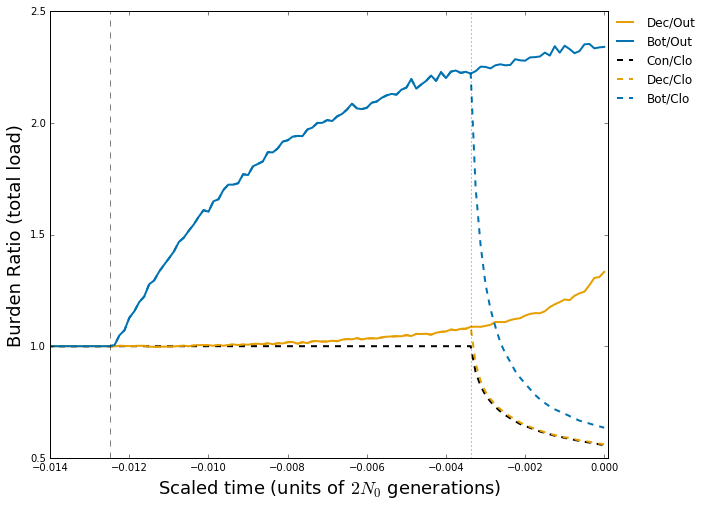

In [37]:
fig = plt.figure(figsize=(10,8))

#######Recessive
#const out vs bottle out

f1, = plt.plot(scaled_time,rec_load.lin_outcross_load.mean()/rec_load.const_outcross_load.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')
f2, = plt.plot(scaled_time,rec_load.disc_outcross_load.mean()/rec_load.const_outcross_load.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

f3, = plt.plot(scaled_time,rec_load.const_clonal_load.mean()/rec_load.const_outcross_load.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

f4, = plt.plot(scaled_time,rec_load.lin_clonal_load.mean()/rec_load.const_outcross_load.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')
f5, = plt.plot(scaled_time,rec_load.disc_clonal_load.mean()/rec_load.const_outcross_load.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')


#plt.axhline(y=1,color="black",linestyle='dotted')
plt.axvline(x=-0.0125,color="black",linestyle='dashed',alpha=0.5)
plt.axvline(x=-0.003375,color="black",linestyle='dotted',alpha=0.5)

plt.ylabel("Burden Ratio (total load)",size=18)
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size=18)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)

plt.ylim(0.5,2.5)


#plt.annotate('Clonality begins', xy=(scaled_time[392], 1), xytext=(scaled_time[370], 0.4),
#            arrowprops=dict(facecolor='black', shrink=.01,width=1,headwidth=5),size=15, horizontalalignment='left'
#            )
#plt.annotate('Population size change', xy=(scaled_time[319], 1), xytext=(scaled_time[319], .7),
#            arrowprops=dict(facecolor='black', shrink=.01,width=1,headwidth=5),size=15, horizontalalignment='center'
#            )

#Global
plt.xlim(-0.014,0.0001)
fig.savefig('plots/rec_load_burdenratio_time_combined.pdf',bbox_inches='tight')
plt.show()

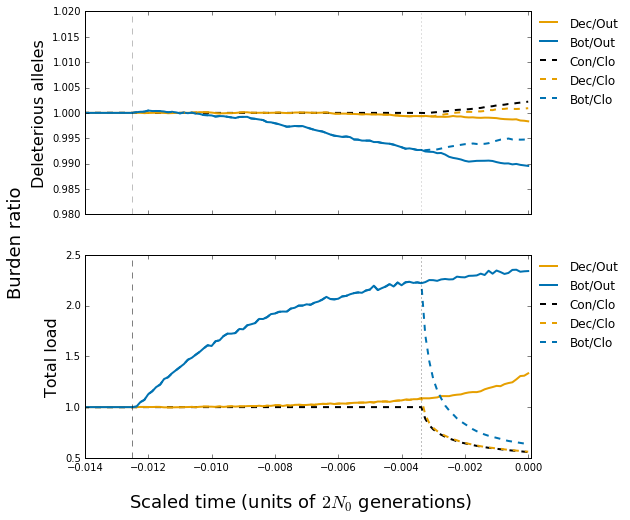

In [38]:
f, axarr = plt.subplots(2,1,sharex=True,sharey=False,figsize=(8,8))
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

#######Recessive
###Mutations
#const out vs bottle out

axarr[0].plot(scaled_time,rec_delmut.lin_outcross_delmut.mean()/rec_delmut.const_outcross_delmut.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')
axarr[0].plot(scaled_time,rec_delmut.disc_outcross_delmut.mean()/rec_delmut.const_outcross_delmut.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

axarr[0].plot(scaled_time,rec_delmut.const_clonal_delmut.mean()/rec_delmut.const_outcross_delmut.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

axarr[0].plot(scaled_time,rec_delmut.lin_clonal_delmut.mean()/rec_delmut.const_outcross_delmut.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')
axarr[0].plot(scaled_time,rec_delmut.disc_clonal_delmut.mean()/rec_delmut.const_outcross_delmut.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')

axarr[0].axvline(x=-0.0125,color="black",linestyle='dashed',alpha=0.25)
axarr[0].axvline(x=-0.003375,color="black",linestyle='dotted',alpha=0.25)
axarr[0].set_ylabel("Deleterious alleles",size=16)
axarr[0].legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
axarr[0].set_ylim(0.98,1.02)


#######Load
#const out vs bottle out

axarr[1].plot(scaled_time,rec_load.lin_outcross_load.mean()/rec_load.const_outcross_load.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')
axarr[1].plot(scaled_time,rec_load.disc_outcross_load.mean()/rec_load.const_outcross_load.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

axarr[1].plot(scaled_time,rec_load.const_clonal_load.mean()/rec_load.const_outcross_load.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

axarr[1].plot(scaled_time,rec_load.lin_clonal_load.mean()/rec_load.const_outcross_load.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')
axarr[1].plot(scaled_time,rec_load.disc_clonal_load.mean()/rec_load.const_outcross_load.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')

axarr[1].axvline(x=-0.0125,color="black",linestyle='dashed',alpha=0.5)
axarr[1].axvline(x=-0.003375,color="black",linestyle='dotted',alpha=0.5)
axarr[1].set_ylabel("Total load",size=16)
axarr[1].legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
axarr[1].set_ylim(0.5,2.5)

#axarr[0].get_yaxis().set_major_formatter(FormatStrFormatter('%s'))
#axarr[1].get_yaxis().set_major_formatter(FormatStrFormatter('%s'))

#Global
plt.xlim(-0.014,0.0001)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=18, ha='center')
f.text(-0.01, 0.5, "Burden ratio",size=18, va='center', rotation='vertical')
f.savefig('plots/rec_load_delmut_burdenratio_time_combined.pdf',bbox_inches='tight')
plt.show()

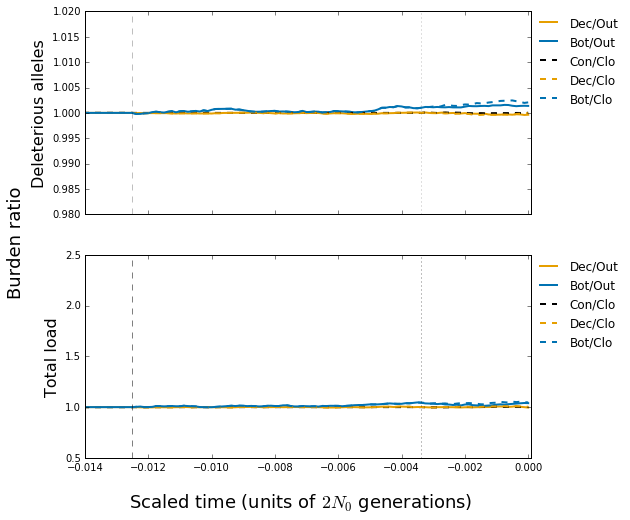

In [18]:
f, axarr = plt.subplots(2,1,sharex=True,sharey=False,figsize=(8,8))
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

#######Additive
#######Mutations
#const out vs bottle out

axarr[0].plot(scaled_time,add_delmut.lin_outcross_delmut.mean()/add_delmut.const_outcross_delmut.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')
axarr[0].plot(scaled_time,add_delmut.disc_outcross_delmut.mean()/add_delmut.const_outcross_delmut.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

axarr[0].plot(scaled_time,add_delmut.const_clonal_delmut.mean()/add_delmut.const_outcross_delmut.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

axarr[0].plot(scaled_time,add_delmut.lin_clonal_delmut.mean()/add_delmut.const_outcross_delmut.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')
axarr[0].plot(scaled_time,add_delmut.disc_clonal_delmut.mean()/add_delmut.const_outcross_delmut.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')

axarr[0].axvline(x=-0.0125,color="black",linestyle='dashed',alpha=0.25)
axarr[0].axvline(x=-0.003375,color="black",linestyle='dotted',alpha=0.25)
axarr[0].set_ylabel("Deleterious alleles",size=16)
axarr[0].legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
axarr[0].set_ylim(0.98,1.02)


#######Load
#const out vs bottle out

axarr[1].plot(scaled_time,add_load.lin_outcross_load.mean()/add_load.const_outcross_load.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')
axarr[1].plot(scaled_time,add_load.disc_outcross_load.mean()/add_load.const_outcross_load.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

axarr[1].plot(scaled_time,add_load.const_clonal_load.mean()/add_load.const_outcross_load.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

axarr[1].plot(scaled_time,add_load.lin_clonal_load.mean()/add_load.const_outcross_load.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')
axarr[1].plot(scaled_time,add_load.disc_clonal_load.mean()/add_load.const_outcross_load.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')

axarr[1].axvline(x=-0.0125,color="black",linestyle='dashed',alpha=0.5)
axarr[1].axvline(x=-0.003375,color="black",linestyle='dotted',alpha=0.5)
axarr[1].set_ylabel("Total load",size=16)
axarr[1].legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
axarr[1].set_ylim(0.5,2.5)

#axarr[0].get_yaxis().set_major_formatter(FormatStrFormatter('%s'))
#axarr[1].get_yaxis().set_major_formatter(FormatStrFormatter('%s'))

#Global
plt.xlim(-0.014,0.0001)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=18, ha='center')
f.text(-0.01, 0.5, "Burden ratio",size=18, va='center', rotation='vertical')
f.savefig('plots/add_load_delmut_burdenratio_time_combined.pdf',bbox_inches='tight')
plt.show()

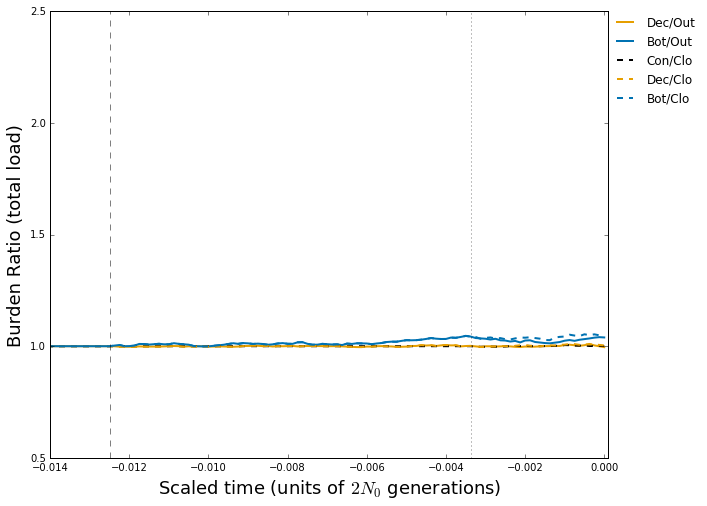

In [38]:
fig = plt.figure(figsize=(10,8))

#######Recessive
#const out vs bottle out

f1, = plt.plot(scaled_time,add_load.lin_outcross_load.mean()/add_load.const_outcross_load.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')
f2, = plt.plot(scaled_time,add_load.disc_outcross_load.mean()/add_load.const_outcross_load.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

f3, = plt.plot(scaled_time,add_load.const_clonal_load.mean()/add_load.const_outcross_load.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

f4, = plt.plot(scaled_time,add_load.lin_clonal_load.mean()/add_load.const_outcross_load.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')
f5, = plt.plot(scaled_time,add_load.disc_clonal_load.mean()/add_load.const_outcross_load.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')


#plt.axhline(y=1,color="black",linestyle='dotted'alpha=0.25)
plt.axvline(x=-0.0125,color="black",linestyle='dashed',alpha=0.5)
plt.axvline(x=-0.003375,color="black",linestyle='dotted',alpha=0.5)
 
plt.ylabel("Burden Ratio (total load)",size=18)
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size=18)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
plt.ylim(0.5,2.5)


#plt.annotate('Clonality begins', xy=(scaled_time[392], 1), xytext=(scaled_time[370], 0.94),
#            arrowprops=dict(facecolor='black', shrink=.01,width=1,headwidth=5),size=15, horizontalalignment='left'
#            )
#plt.annotate('Population size change', xy=(scaled_time[319], 1), xytext=(scaled_time[319], 1.07),
#            arrowprops=dict(facecolor='black', shrink=.01,width=1,headwidth=5),size=15, horizontalalignment='center'
#            )

#Global
plt.xlim(-0.014,0.0001)
fig.savefig('plots/add_load_burdenratio_time_combined.pdf',bbox_inches='tight')
plt.show()

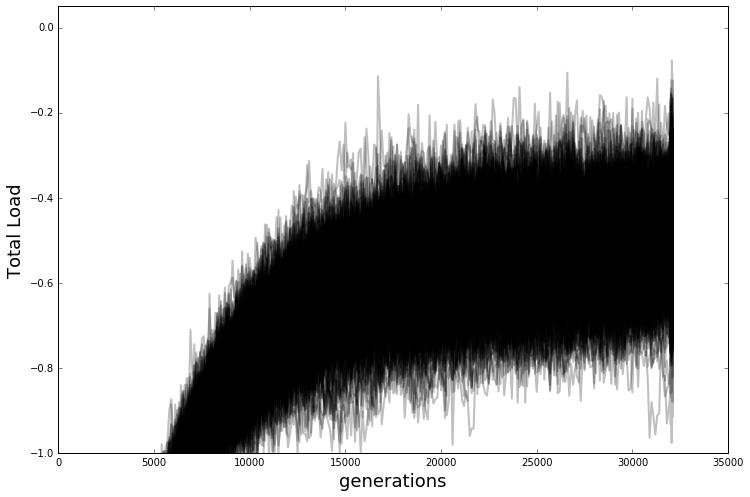

In [189]:
fig = plt.figure(figsize=(12,8))
for i in range(500):
#i=274
    rec_gens = rec_pkl_data[i]['ancestral'].generation + rec_pkl_data[i]['const_decl'].generation + rec_pkl_data[i]['const_domest_out'].generation
    #fig = plt.figure(figsize=(10,8))

    rec_load = rec_pkl_data[i]['ancestral'].total_tajd + rec_pkl_data[i]['const_decl'].total_tajd + rec_pkl_data[i]['const_domest_out'].total_tajd


    #######Recessive
    #const out vs bottle out
    f, = plt.plot(pd.DataFrame(rec_gens),pd.DataFrame(rec_load),
                     label='Constant + Outcrossing',
                     color="#000000",alpha=0.25,
                    lw=2,
                 linestyle='solid')

plt.ylabel("Total Load",size=18)
plt.xlabel(r'generations',size=18)
#plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
plt.ylim(-1,0.05)

#Global
#plt.xlim(-4,0.0001)
#fig.savefig('plots/rec_total_load_examples.pdf',bbox_inches='tight')
plt.show()

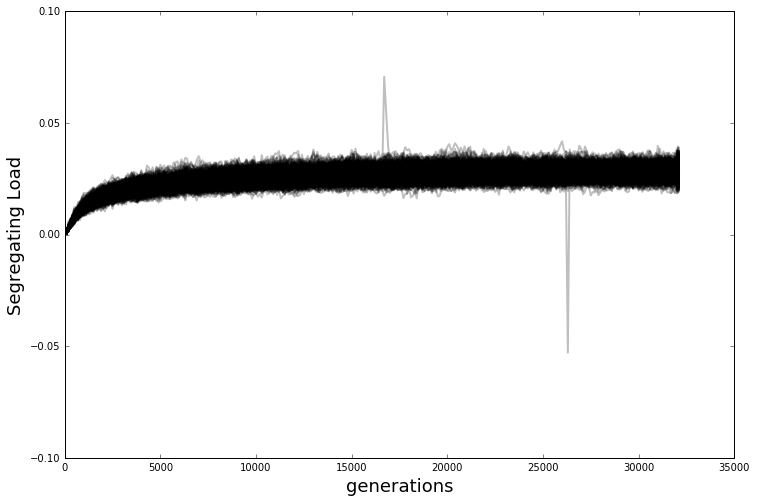

In [181]:
fig = plt.figure(figsize=(12,8))
for i in range(500):
#i=274
    rec_gens = rec_pkl_data[i]['ancestral'].generation + rec_pkl_data[i]['const_decl'].generation + rec_pkl_data[i]['const_domest_out'].generation
    #fig = plt.figure(figsize=(10,8))

    rec_load = rec_pkl_data[i]['ancestral'].segregating_load + rec_pkl_data[i]['const_decl'].segregating_load + rec_pkl_data[i]['const_domest_out'].segregating_load


    #######Recessive
    #const out vs bottle out
    f, = plt.plot(pd.DataFrame(rec_gens),pd.DataFrame(rec_load),
                     label='Constant + Outcrossing',
                     color="#000000",alpha=0.25,
                    lw=2,
                 linestyle='solid')

plt.ylabel("Segregating Load",size=18)
plt.xlabel(r'generations',size=18)
#plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
plt.ylim(-.1,0.1)

#Global
#plt.xlim(-4,0.0001)
fig.savefig('plots/rec_seg_load_examples.pdf',bbox_inches='tight')
plt.show()

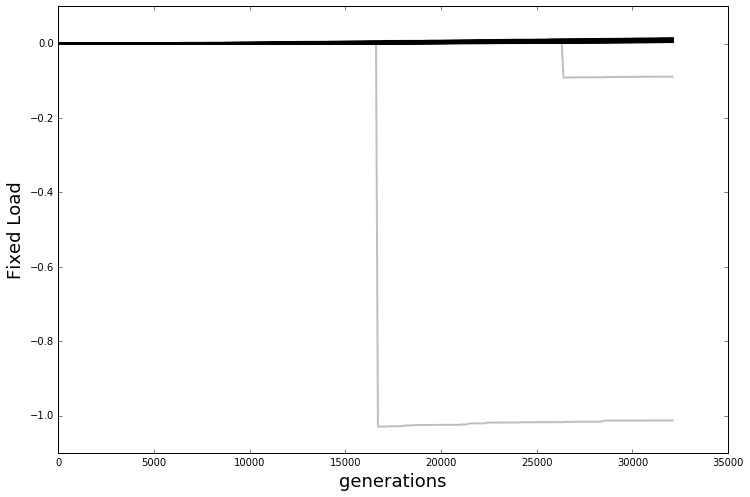

In [188]:
fig = plt.figure(figsize=(12,8))
for i in range(500):
#i=274
    rec_gens = rec_pkl_data[i]['ancestral'].generation + rec_pkl_data[i]['const_decl'].generation + rec_pkl_data[i]['const_domest_out'].generation
    #fig = plt.figure(figsize=(10,8))

    rec_load = rec_pkl_data[i]['ancestral'].fixed_load + rec_pkl_data[i]['lin_decl'].fixed_load + rec_pkl_data[i]['lin_domest_out'].fixed_load


    #######Recessive
    #const out vs bottle out
    f, = plt.plot(pd.DataFrame(rec_gens),pd.DataFrame(rec_load),
                     label='Constant + Outcrossing',
                     color="#000000",alpha=0.25,
                    lw=2,
                 linestyle='solid')

plt.ylabel("Fixed Load",size=18)
plt.xlabel(r'generations',size=18)
#plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
plt.ylim(-1.1,0.1)

#Global
#plt.xlim(-4,0.0001)
#fig.savefig('plots/rec_fixed_load_examples.pdf',bbox_inches='tight')
plt.show()

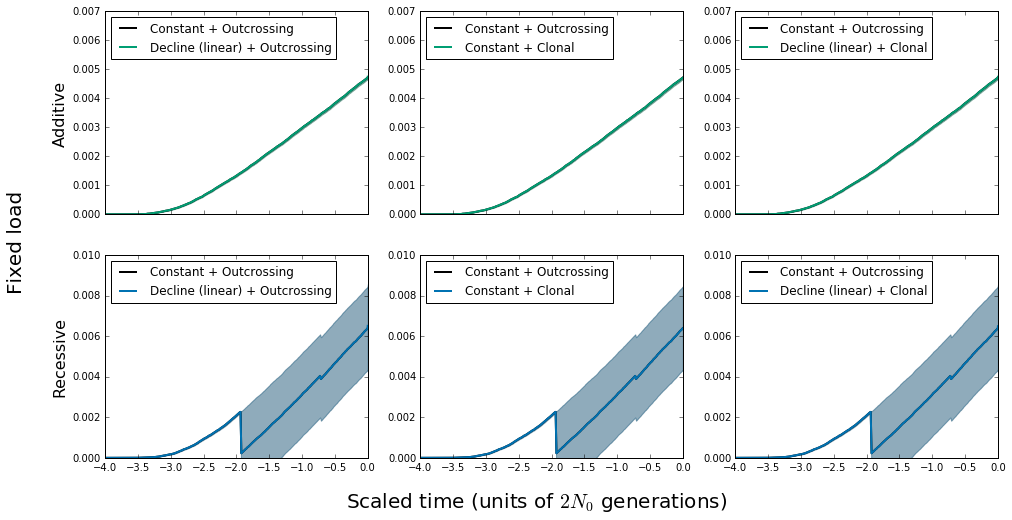

In [107]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=False,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_fixed_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_fixed_load.const_outcross_load.mean() - np.sqrt(add_fixed_load.const_outcross_load.var()/500),
add_fixed_load.const_outcross_load.mean() + np.sqrt(add_fixed_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_fixed_load.lin_outcross_load.mean(),
                 label='Decline (linear) + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_fixed_load.lin_outcross_load.mean() - np.sqrt(add_fixed_load.lin_outcross_load.var()/500),
add_fixed_load.lin_outcross_load.mean() + np.sqrt(add_fixed_load.lin_outcross_load.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')

#const out vs const clonal
axarr[0,1].plot(scaled_time,add_fixed_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_fixed_load.const_outcross_load.mean() - np.sqrt(add_fixed_load.const_outcross_load.var()/500),
add_fixed_load.const_outcross_load.mean() + np.sqrt(add_fixed_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_fixed_load.const_clonal_load.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_fixed_load.const_clonal_load.mean() - np.sqrt(add_fixed_load.const_clonal_load.var()/500),
add_fixed_load.const_clonal_load.mean() + np.sqrt(add_fixed_load.const_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_fixed_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_fixed_load.const_outcross_load.mean() - np.sqrt(add_fixed_load.const_outcross_load.var()/500),
add_fixed_load.const_outcross_load.mean() + np.sqrt(add_fixed_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_fixed_load.lin_clonal_load.mean(),
                 label='Decline (linear) + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_fixed_load.lin_clonal_load.mean() - np.sqrt(add_fixed_load.lin_clonal_load.var()/500),
add_fixed_load.lin_clonal_load.mean() + np.sqrt(add_fixed_load.lin_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')

#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_fixed_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_fixed_load.const_outcross_load.mean() - np.sqrt(rec_fixed_load.const_outcross_load.var()/500),
rec_fixed_load.const_outcross_load.mean() + np.sqrt(rec_fixed_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_fixed_load.lin_outcross_load.mean(),
                 label='Decline (linear) + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_fixed_load.lin_outcross_load.mean() - np.sqrt(rec_fixed_load.lin_outcross_load.var()/500),
rec_fixed_load.lin_outcross_load.mean() + np.sqrt(rec_fixed_load.lin_outcross_load.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_fixed_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_fixed_load.const_outcross_load.mean() - np.sqrt(rec_fixed_load.const_outcross_load.var()/500),
rec_fixed_load.const_outcross_load.mean() + np.sqrt(rec_fixed_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_fixed_load.const_clonal_load.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_fixed_load.const_clonal_load.mean() - np.sqrt(rec_fixed_load.const_clonal_load.var()/500),
rec_fixed_load.const_clonal_load.mean() + np.sqrt(rec_fixed_load.const_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')
#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_fixed_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_fixed_load.const_outcross_load.mean() - np.sqrt(rec_fixed_load.const_outcross_load.var()/500),
rec_fixed_load.const_outcross_load.mean() + np.sqrt(rec_fixed_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_fixed_load.lin_clonal_load.mean(),
                 label='Decline (linear) + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_fixed_load.lin_clonal_load.mean() - np.sqrt(rec_fixed_load.lin_clonal_load.var()/500),
rec_fixed_load.lin_clonal_load.mean() + np.sqrt(rec_fixed_load.lin_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')

axarr[0,0].set_ylim(0.0,0.007)
axarr[0,1].set_ylim(0.0,0.007)
axarr[0,2].set_ylim(0.0,0.007)

axarr[1,0].set_ylim(0.0,0.01)
axarr[1,1].set_ylim(0.0,0.01)
axarr[1,2].set_ylim(0.0,0.01)


#Global
plt.xlim(-4,0.0001)
f.text(0.5, 0.04, 'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Fixed load",size=20, va='center', rotation='vertical')
f.savefig('plots/lin_fixed_load_time_combined.pdf')
plt.show()

# Discrete decline plots

# Tajima's D

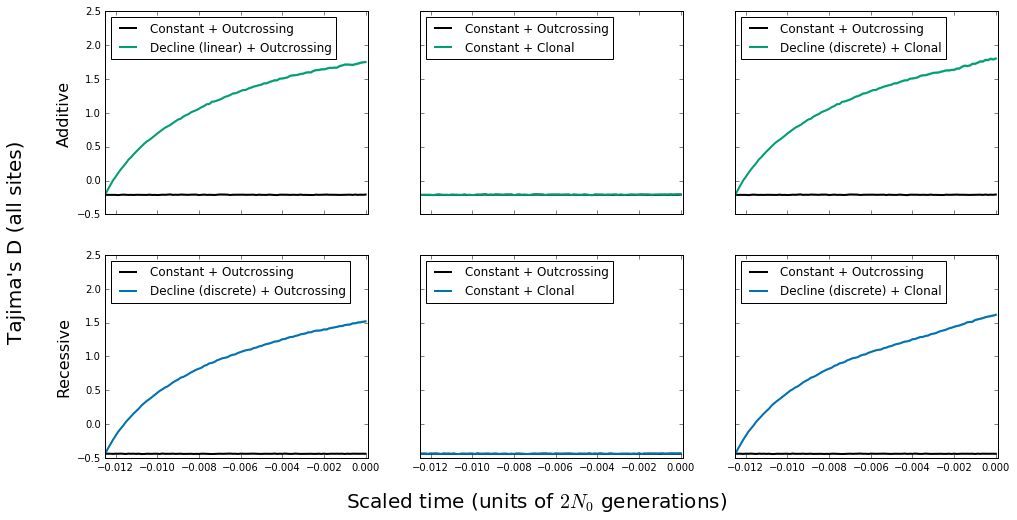

In [64]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=True,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_tajd.disc_outcross_tajd.mean(),
                 label='Decline (linear) + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_tajd.disc_outcross_tajd.mean() - np.sqrt(add_tajd.disc_outcross_tajd.var()/500),
add_tajd.disc_outcross_tajd.mean() + np.sqrt(add_tajd.disc_outcross_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')

#const out vs const clonal
axarr[0,1].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_tajd.const_clonal_tajd.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_tajd.const_clonal_tajd.mean() - np.sqrt(add_tajd.const_clonal_tajd.var()/500),
add_tajd.const_clonal_tajd.mean() + np.sqrt(add_tajd.const_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_tajd.disc_clonal_tajd.mean(),
                 label='Decline (discrete) + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_tajd.disc_clonal_tajd.mean() - np.sqrt(add_tajd.disc_clonal_tajd.var()/500),
add_tajd.disc_clonal_tajd.mean() + np.sqrt(add_tajd.disc_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')

#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_tajd.disc_outcross_tajd.mean(),
                 label='Decline (discrete) + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_tajd.disc_outcross_tajd.mean() - np.sqrt(rec_tajd.disc_outcross_tajd.var()/500),
rec_tajd.disc_outcross_tajd.mean() + np.sqrt(rec_tajd.disc_outcross_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_tajd.const_clonal_tajd.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_tajd.const_clonal_tajd.mean() - np.sqrt(rec_tajd.const_clonal_tajd.var()/500),
rec_tajd.const_clonal_tajd.mean() + np.sqrt(rec_tajd.const_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')
#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_tajd.disc_clonal_tajd.mean(),
                 label='Decline (discrete) + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_tajd.disc_clonal_tajd.mean() - np.sqrt(rec_tajd.disc_clonal_tajd.var()/500),
rec_tajd.disc_clonal_tajd.mean() + np.sqrt(rec_tajd.disc_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')

#Global
plt.xlim(-0.0125,0.0001)
plt.ylim(-0.5,2.5)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Tajima's D (all sites)",size=20, va='center', rotation='vertical')
f.savefig('plots/disc_tajd_time_combined.pdf')
plt.show()

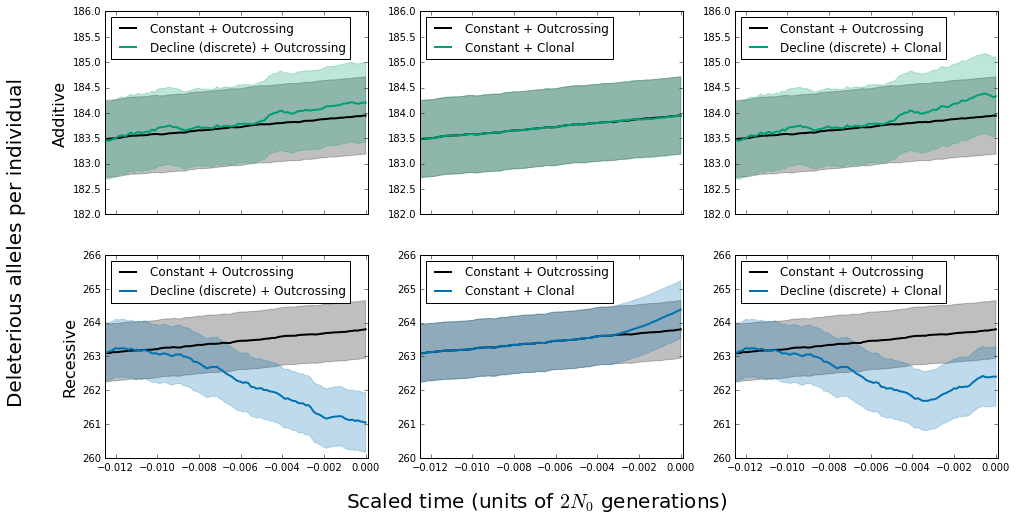

In [66]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=False,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_delmut.disc_outcross_delmut.mean(),
                 label='Decline (discrete) + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_delmut.disc_outcross_delmut.mean() - np.sqrt(add_delmut.disc_outcross_delmut.var()/500),
add_delmut.disc_outcross_delmut.mean() + np.sqrt(add_delmut.disc_outcross_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')

#const out vs const clonal
axarr[0,1].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_delmut.const_clonal_delmut.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_delmut.const_clonal_delmut.mean() - np.sqrt(add_delmut.const_clonal_delmut.var()/500),
add_delmut.const_clonal_delmut.mean() + np.sqrt(add_delmut.const_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_delmut.disc_clonal_delmut.mean(),
                 label='Decline (discrete) + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_delmut.disc_clonal_delmut.mean() - np.sqrt(add_delmut.disc_clonal_delmut.var()/500),
add_delmut.disc_clonal_delmut.mean() + np.sqrt(add_delmut.disc_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')

#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_delmut.disc_outcross_delmut.mean(),
                 label='Decline (discrete) + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_delmut.disc_outcross_delmut.mean() - np.sqrt(rec_delmut.disc_outcross_delmut.var()/500),
rec_delmut.disc_outcross_delmut.mean() + np.sqrt(rec_delmut.disc_outcross_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_delmut.const_clonal_delmut.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_delmut.const_clonal_delmut.mean() - np.sqrt(rec_delmut.const_clonal_delmut.var()/500),
rec_delmut.const_clonal_delmut.mean() + np.sqrt(rec_delmut.const_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_delmut.disc_clonal_delmut.mean(),
                 label='Decline (discrete) + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_delmut.disc_clonal_delmut.mean() - np.sqrt(rec_delmut.disc_clonal_delmut.var()/500),
rec_delmut.disc_clonal_delmut.mean() + np.sqrt(rec_delmut.disc_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')

axarr[0,0].set_ylim(182,186)
axarr[0,1].set_ylim(182,186)
axarr[0,2].set_ylim(182,186)
axarr[1,0].set_ylim(260,266)
axarr[1,1].set_ylim(260,266)
axarr[1,2].set_ylim(260,266)


#Global
plt.xlim(-0.0125,0.0001)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Deleterious alleles per individual",size=20, va='center', rotation='vertical')
f.savefig('plots/disc_delmut_time_combined.pdf')
plt.show()

# Load

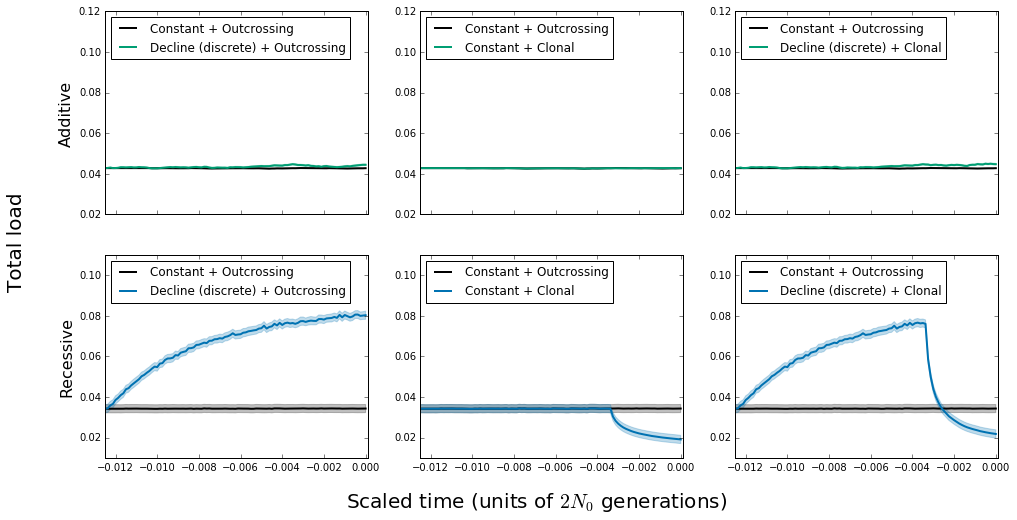

In [92]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=False,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_load.const_outcross_load.mean() - np.sqrt(add_load.const_outcross_load.var()/500),
add_load.const_outcross_load.mean() + np.sqrt(add_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_load.disc_outcross_load.mean(),
                 label='Decline (discrete) + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_load.disc_outcross_load.mean() - np.sqrt(add_load.disc_outcross_load.var()/500),
add_load.disc_outcross_load.mean() + np.sqrt(add_load.disc_outcross_load.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')

#const out vs const clonal
axarr[0,1].plot(scaled_time,add_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_load.const_outcross_load.mean() - np.sqrt(add_load.const_outcross_load.var()/500),
add_load.const_outcross_load.mean() + np.sqrt(add_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_load.const_clonal_load.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_load.const_clonal_load.mean() - np.sqrt(add_load.const_clonal_load.var()/500),
add_load.const_clonal_load.mean() + np.sqrt(add_load.const_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_load.const_outcross_load.mean() - np.sqrt(add_load.const_outcross_load.var()/500),
add_load.const_outcross_load.mean() + np.sqrt(add_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_load.disc_clonal_load.mean(),
                 label='Decline (discrete) + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_load.disc_clonal_load.mean() - np.sqrt(add_load.disc_clonal_load.var()/500),
add_load.disc_clonal_load.mean() + np.sqrt(add_load.disc_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')

#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_load.const_outcross_load.mean() - np.sqrt(rec_load.const_outcross_load.var()/500),
rec_load.const_outcross_load.mean() + np.sqrt(rec_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_load.disc_outcross_load.mean(),
                 label='Decline (discrete) + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_load.disc_outcross_load.mean() - np.sqrt(rec_load.disc_outcross_load.var()/500),
rec_load.disc_outcross_load.mean() + np.sqrt(rec_load.disc_outcross_load.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_load.const_outcross_load.mean() - np.sqrt(rec_load.const_outcross_load.var()/500),
rec_load.const_outcross_load.mean() + np.sqrt(rec_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_load.const_clonal_load.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_load.const_clonal_load.mean() - np.sqrt(rec_load.const_clonal_load.var()/500),
rec_load.const_clonal_load.mean() + np.sqrt(rec_load.const_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')
#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_load.const_outcross_load.mean() - np.sqrt(rec_load.const_outcross_load.var()/500),
rec_load.const_outcross_load.mean() + np.sqrt(rec_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_load.disc_clonal_load.mean(),
                 label='Decline (discrete) + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_load.disc_clonal_load.mean() - np.sqrt(rec_load.disc_clonal_load.var()/500),
rec_load.disc_clonal_load.mean() + np.sqrt(rec_load.disc_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')

axarr[0,0].set_ylim(0.02,0.12)
axarr[0,1].set_ylim(0.02,0.12)
axarr[0,2].set_ylim(0.02,0.12)

axarr[1,0].set_ylim(0.01,0.11)
axarr[1,1].set_ylim(0.01,0.11)
axarr[1,2].set_ylim(0.01,0.11)


#Global
plt.xlim(-0.0125,0.0001)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Total load",size=20, va='center', rotation='vertical')
f.savefig('plots/disc_load_time_combined.pdf')
plt.show()

# Exponential Decline

# Tajima's D

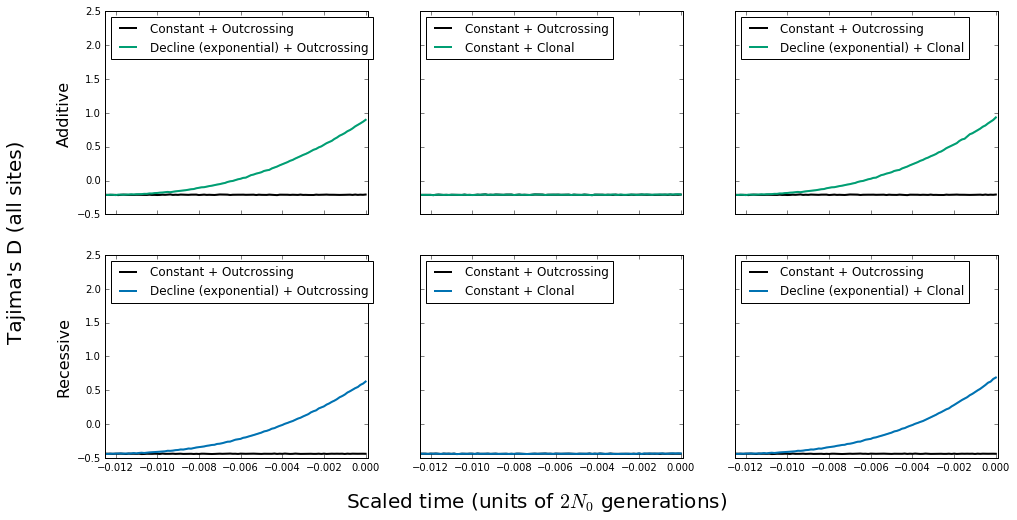

In [67]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=True,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_tajd.exp_outcross_tajd.mean(),
                 label='Decline (exponential) + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_tajd.exp_outcross_tajd.mean() - np.sqrt(add_tajd.exp_outcross_tajd.var()/500),
add_tajd.exp_outcross_tajd.mean() + np.sqrt(add_tajd.exp_outcross_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')

#const out vs const clonal
axarr[0,1].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_tajd.const_clonal_tajd.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_tajd.const_clonal_tajd.mean() - np.sqrt(add_tajd.const_clonal_tajd.var()/500),
add_tajd.const_clonal_tajd.mean() + np.sqrt(add_tajd.const_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_tajd.exp_clonal_tajd.mean(),
                 label='Decline (exponential) + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_tajd.exp_clonal_tajd.mean() - np.sqrt(add_tajd.exp_clonal_tajd.var()/500),
add_tajd.exp_clonal_tajd.mean() + np.sqrt(add_tajd.exp_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')

#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_tajd.exp_outcross_tajd.mean(),
                 label='Decline (exponential) + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_tajd.exp_outcross_tajd.mean() - np.sqrt(rec_tajd.exp_outcross_tajd.var()/500),
rec_tajd.exp_outcross_tajd.mean() + np.sqrt(rec_tajd.exp_outcross_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_tajd.const_clonal_tajd.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_tajd.const_clonal_tajd.mean() - np.sqrt(rec_tajd.const_clonal_tajd.var()/500),
rec_tajd.const_clonal_tajd.mean() + np.sqrt(rec_tajd.const_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')
#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_tajd.exp_clonal_tajd.mean(),
                 label='Decline (exponential) + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_tajd.exp_clonal_tajd.mean() - np.sqrt(rec_tajd.exp_clonal_tajd.var()/500),
rec_tajd.exp_clonal_tajd.mean() + np.sqrt(rec_tajd.exp_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')

#Global
plt.xlim(-0.0125,0.0001)
plt.ylim(-0.5,2.5)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Tajima's D (all sites)",size=20, va='center', rotation='vertical')
f.savefig('plots/exp_tajd_time_combined.pdf')
plt.show()

# Total deleterious mutations

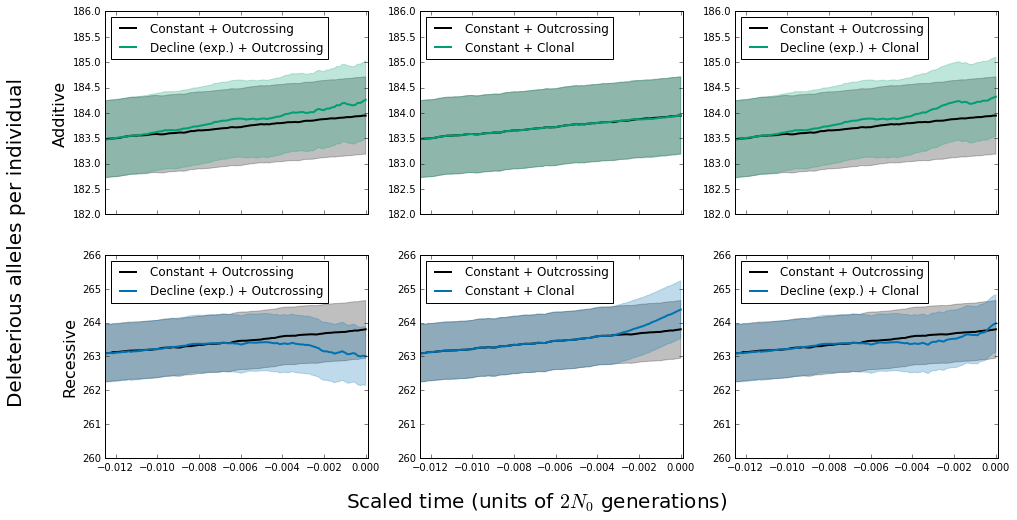

In [69]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=False,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_delmut.exp_outcross_delmut.mean(),
                 label='Decline (exp.) + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_delmut.exp_outcross_delmut.mean() - np.sqrt(add_delmut.exp_outcross_delmut.var()/500),
add_delmut.exp_outcross_delmut.mean() + np.sqrt(add_delmut.exp_outcross_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')

#const out vs const clonal
axarr[0,1].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_delmut.const_clonal_delmut.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_delmut.const_clonal_delmut.mean() - np.sqrt(add_delmut.const_clonal_delmut.var()/500),
add_delmut.const_clonal_delmut.mean() + np.sqrt(add_delmut.const_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_delmut.exp_clonal_delmut.mean(),
                 label='Decline (exp.) + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_delmut.exp_clonal_delmut.mean() - np.sqrt(add_delmut.exp_clonal_delmut.var()/500),
add_delmut.exp_clonal_delmut.mean() + np.sqrt(add_delmut.exp_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')

#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_delmut.exp_outcross_delmut.mean(),
                 label='Decline (exp.) + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_delmut.exp_outcross_delmut.mean() - np.sqrt(rec_delmut.exp_outcross_delmut.var()/500),
rec_delmut.exp_outcross_delmut.mean() + np.sqrt(rec_delmut.exp_outcross_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_delmut.const_clonal_delmut.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_delmut.const_clonal_delmut.mean() - np.sqrt(rec_delmut.const_clonal_delmut.var()/500),
rec_delmut.const_clonal_delmut.mean() + np.sqrt(rec_delmut.const_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_delmut.exp_clonal_delmut.mean(),
                 label='Decline (exp.) + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_delmut.exp_clonal_delmut.mean() - np.sqrt(rec_delmut.exp_clonal_delmut.var()/500),
rec_delmut.exp_clonal_delmut.mean() + np.sqrt(rec_delmut.exp_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')

axarr[0,0].set_ylim(182,186)
axarr[0,1].set_ylim(182,186)
axarr[0,2].set_ylim(182,186)
axarr[1,0].set_ylim(260,266)
axarr[1,1].set_ylim(260,266)
axarr[1,2].set_ylim(260,266)


#Global
plt.xlim(-0.0125,0.0001)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Deleterious alleles per individual",size=20, va='center', rotation='vertical')
f.savefig('plots/exp_delmut_time_combined.pdf')
plt.show()

# Load

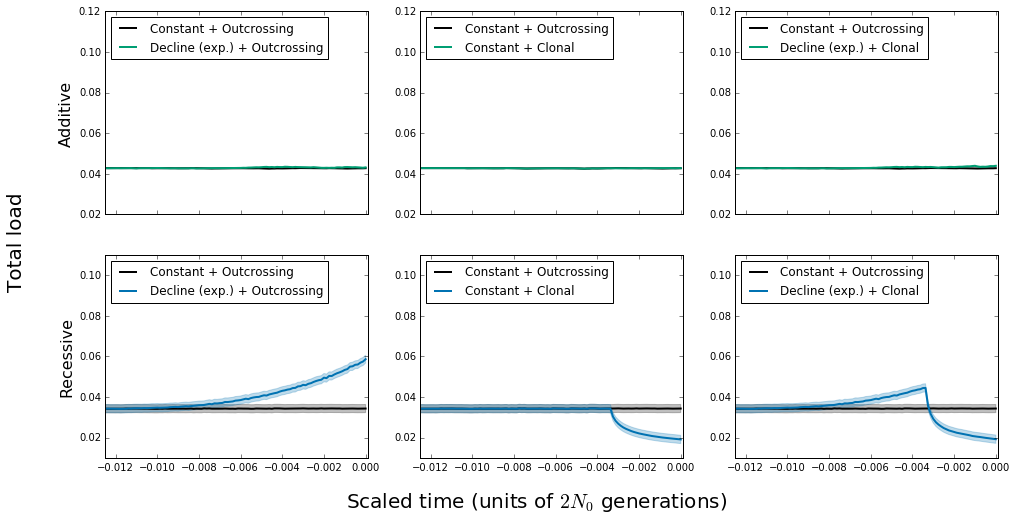

In [93]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=False,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_load.const_outcross_load.mean() - np.sqrt(add_load.const_outcross_load.var()/500),
add_load.const_outcross_load.mean() + np.sqrt(add_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_load.exp_outcross_load.mean(),
                 label='Decline (exp.) + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_load.exp_outcross_load.mean() - np.sqrt(add_load.exp_outcross_load.var()/500),
add_load.exp_outcross_load.mean() + np.sqrt(add_load.exp_outcross_load.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')

#const out vs const clonal
axarr[0,1].plot(scaled_time,add_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_load.const_outcross_load.mean() - np.sqrt(add_load.const_outcross_load.var()/500),
add_load.const_outcross_load.mean() + np.sqrt(add_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_load.const_clonal_load.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_load.const_clonal_load.mean() - np.sqrt(add_load.const_clonal_load.var()/500),
add_load.const_clonal_load.mean() + np.sqrt(add_load.const_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_load.const_outcross_load.mean() - np.sqrt(add_load.const_outcross_load.var()/500),
add_load.const_outcross_load.mean() + np.sqrt(add_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_load.exp_clonal_load.mean(),
                 label='Decline (exp.) + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_load.exp_clonal_load.mean() - np.sqrt(add_load.exp_clonal_load.var()/500),
add_load.exp_clonal_load.mean() + np.sqrt(add_load.exp_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')

#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_load.const_outcross_load.mean() - np.sqrt(rec_load.const_outcross_load.var()/500),
rec_load.const_outcross_load.mean() + np.sqrt(rec_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_load.exp_outcross_load.mean(),
                 label='Decline (exp.) + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_load.exp_outcross_load.mean() - np.sqrt(rec_load.exp_outcross_load.var()/500),
rec_load.exp_outcross_load.mean() + np.sqrt(rec_load.exp_outcross_load.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_load.const_outcross_load.mean() - np.sqrt(rec_load.const_outcross_load.var()/500),
rec_load.const_outcross_load.mean() + np.sqrt(rec_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_load.const_clonal_load.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_load.const_clonal_load.mean() - np.sqrt(rec_load.const_clonal_load.var()/500),
rec_load.const_clonal_load.mean() + np.sqrt(rec_load.const_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')
#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_load.const_outcross_load.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_load.const_outcross_load.mean() - np.sqrt(rec_load.const_outcross_load.var()/500),
rec_load.const_outcross_load.mean() + np.sqrt(rec_load.const_outcross_load.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_load.exp_clonal_load.mean(),
                 label='Decline (exp.) + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_load.exp_clonal_load.mean() - np.sqrt(rec_load.exp_clonal_load.var()/500),
rec_load.exp_clonal_load.mean() + np.sqrt(rec_load.exp_clonal_load.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')

axarr[0,0].set_ylim(0.02,0.12)
axarr[0,1].set_ylim(0.02,0.12)
axarr[0,2].set_ylim(0.02,0.12)

axarr[1,0].set_ylim(0.01,0.11)
axarr[1,1].set_ylim(0.01,0.11)
axarr[1,2].set_ylim(0.01,0.11)


#Global
plt.xlim(-0.0125,0.0001)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Total load",size=20, va='center', rotation='vertical')
f.savefig('plots/exp_load_time_combined.pdf')
plt.show()

# Combined deleterious mutations plot

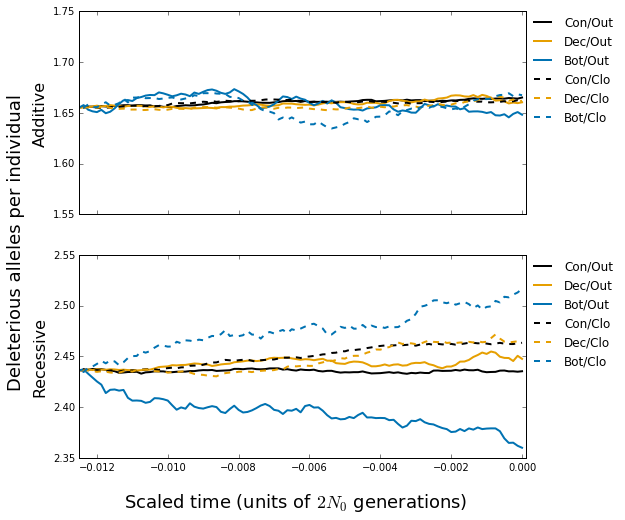

In [29]:
f, axarr = plt.subplots(2,1,sharex=True,sharey=False,figsize=(8,8))
#######Additive
#const out vs bottle out
axarr[0].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Con/Out',
                 color="#000000",
                lw=2,
             linestyle='solid')

axarr[0].plot(scaled_time,add_delmut.bottle_outcross_delmut.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')

axarr[0].plot(scaled_time,disc_add_delmut.bottle_outcross_delmut.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

axarr[0].plot(scaled_time,add_delmut.const_clonal_delmut.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

axarr[0].plot(scaled_time,add_delmut.bottle_clonal_delmut.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')

axarr[0].plot(scaled_time,disc_add_delmut.bottle_clonal_delmut.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')

axarr[0].set_ylabel("Additive",size=16)
axarr[0].legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
axarr[0].set_ylim(1.55,1.75)
#const out vs const clonal

#######Recessive
#const out vs bottle out
axarr[1].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Con/Out',
                 color="#000000",
                lw=2,
             linestyle='solid')

axarr[1].plot(scaled_time,rec_delmut.bottle_outcross_delmut.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')

axarr[1].plot(scaled_time,disc_rec_delmut.bottle_outcross_delmut.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

axarr[1].plot(scaled_time,rec_delmut.const_clonal_delmut.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

axarr[1].plot(scaled_time,rec_delmut.bottle_clonal_delmut.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')

axarr[1].plot(scaled_time,disc_rec_delmut.bottle_clonal_delmut.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')

axarr[1].set_ylabel("Recessive",size=16)
axarr[1].legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
axarr[1].set_ylim(2.35,2.55)

#Global
plt.xlim(-0.0125,0.0001)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=18, ha='center')
f.text(0, 0.5, "Deleterious alleles per individual",size=18, va='center', rotation='vertical')
f.savefig('plots/all_delmut_time_combined.pdf',bbox_inches='tight')
plt.show()

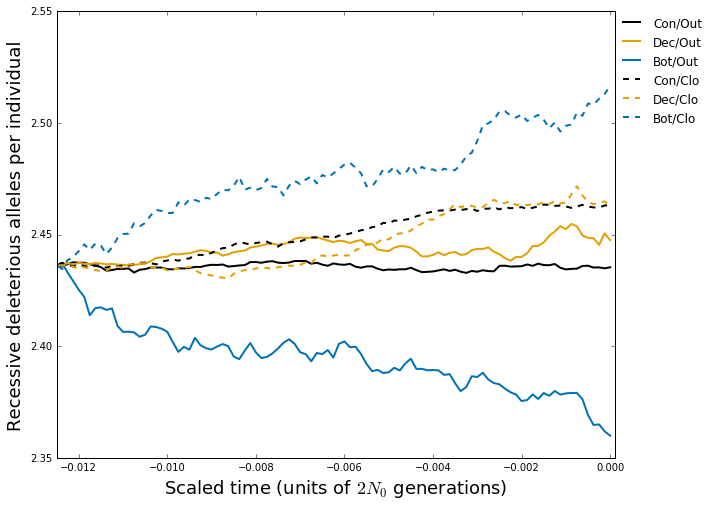

In [35]:
fig = plt.figure(figsize=(10,8))

#######Recessive
#const out vs bottle out
f1, = plt.plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Con/Out',
                 color="#000000",
                lw=2,
             linestyle='solid')

f2, = plt.plot(scaled_time,rec_delmut.bottle_outcross_delmut.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')

f3, = plt.plot(scaled_time,disc_rec_delmut.bottle_outcross_delmut.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

f4, = plt.plot(scaled_time,rec_delmut.const_clonal_delmut.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

f5, = plt.plot(scaled_time,rec_delmut.bottle_clonal_delmut.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')

f6, = plt.plot(scaled_time,disc_rec_delmut.bottle_clonal_delmut.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')




plt.ylabel("Recessive deleterious alleles per individual",size=18)
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size=18)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
plt.ylim(2.35,2.55)

#Global
plt.xlim(-0.0125,0.0001)
fig.savefig('plots/rec_delmut_time_combined.pdf',bbox_inches='tight')
plt.show()